# Data Science Analyze and Present A/B Test Results

X company recently introduced a new bidding type, “average bidding”, as an alternative to its exisiting bidding
type, called “maximum bidding”. One of our clients, X.com, has decided to test this new feature
and wants to conduct an A/B test to understand if average bidding brings more conversions than maximum
bidding.

In this A/B test, X.com randomly splits its audience into two equally sized groups, e.g. the test
and the control group. A X company ad campaign with “maximum bidding” is served to “control group” and
another campaign with “average bidding” is served to the “test group”.

The A/B test has run for 1 month and X.com now expects you to analyze and present the results
of this A/B test.



##### You should answer the following questions in this notebook

1. How would you define the hypothesis of this A/B test?
2. Can we conclude statistically significant results?
3. Which statistical test did you use, and why?
4. Based on your answer to Question 2, what would be your recommendation to client?


##### Hints:

1. The customer journey for this campaign is:
    1. User sees an ad (Impression)
    2. User clicks on the website link on the ad (Website Click)
    3. User makes a search on the website (Search)
    4. User views details of a product (View Content)
    5. User adds the product to the cart (Add to Cart)
    6. User purchases the product (Purchase)
2. Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers.
3. If you see trends, anomalies or other patterns, discuss these in your notebool.
4. You can make assumptions if needed.


## 1. Import libraries

In [52]:
!pip install xls2xlsx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skewtest
from scipy.stats import median_test
from scipy.stats import shapiro
import pylab
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import levene
from statsmodels.stats.proportion import proportions_ztest
from sklearn.impute import KNNImputer

pd.set_option("display.max_columns",None);
pd.set_option("display.max_rows",None);

## 2. Functions

In [53]:
def read_data() :
    """
      Reads and loads control and test group data from an Excel file.
    - **Control group** (Maximum Bidding): Existing campaign data.
    - **Test group** (Average Bidding): Data from the new bidding strategy.
    The function removes rows with NaN values that originated from notes in the Excel file for the control group.
    """
    #Maximum Bidding(Existing)
    control = pd.read_excel("../input/ab-test-dataset/AB_Case_Study.xlsx", sheet_name="Control Group")
    #Average Bidding(New)
    test = pd.read_excel("../input/ab-test-dataset/AB_Case_Study.xlsx", sheet_name="Test Group")

    #In the control dataframe, the rows containing NaN values from the 'note' column (imported from Excel) were removed
    control.drop(control.index[[30,31]], inplace = True)

    return control, test

def get_catvar(df) :
    """
    Identifies and extracts categorical variables from a DataFrame.
    - Returns the original DataFrame, a DataFrame of only categorical variables, and the names of the categorical columns.
    """
    cat_col = [col for col in df.columns if ( (df[col].dtype == 'object') | (df[col].dtype == 'bool'))]
    kat_df = pd.DataFrame(df[cat_col], index = df[cat_col].index)
    return df, kat_df, cat_col

def get_numvar(cat_col,df):
    """
    Identifies and extracts numerical variables from a DataFrame, excluding those specified as categorical.
    - Returns the original DataFrame, a DataFrame of only numerical variables, and the names of the numerical columns.
    """
    num_col = [c for c in df.columns if c not in cat_col]
    num_df = pd.DataFrame(df[num_col], index = df[num_col].index)
    return df, num_df, num_col

def fill_NaNValue(num_control) :
    """
    Implements K-Nearest Neighbors Imputation to fill in missing values in numerical columns of the control group.
    - Returns a DataFrame with missing values filled.
    """
    cols = num_control.columns
    imputer = KNNImputer(n_neighbors=8)
    num_control = imputer.fit_transform(num_control)
    num_control=pd.DataFrame(num_control,columns=cols)
    return num_control

def convert_datatype(control):
    """
      Converts specified columns in the control group DataFrame to integer data types.
    - This is important for ensuring data consistency and correctness in calculations.
    """
    control = control.astype({'# of Impressions' : 'int64',
                        'Reach': 'int64',
                        '# of Website Clicks' : 'int64',
                        '# of Searches': 'int64',
                        '# of View Content': 'int64',
                        '# of Add to Cart': 'int64',
                        '# of Purchase' : 'int64'})
    return control

def outliers(control, test):
    """
    Detects and handles outliers in the test group data using Local Outlier Factor (LOF).
    - Prints scores of the detected outliers and modifies extreme outlier values based on a specified threshold.
    """
    clf= LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)
    clf.fit_predict(test.iloc[:,2:])[0:10]

    test_scores=clf.negative_outlier_factor_
    print("Test Score: " , np.sort(test_scores)[0:20])
    sns.boxplot(test_scores);

    threshold=np.sort(test_scores)[4]
    print("Threshold score: ", threshold)

    test.loc[test_scores < -1.50].index
    test.loc[test_scores == threshold]

    test.iloc[0,2:]=[2742.245945,79574,57168,3086,1263,1098,226,277]
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,3:5]));
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,5:6]));
    sns.boxplot(x="variable", y="value", data=pd.melt(test.iloc[:,6:]));


def feature_engineering(control, test):
    """
    Creates new features for both control and test groups to aid in analysis:
    - Website Click Through Rate: The percentage of clicks per number of impressions.
    - Number of Action: Sum of various engagement metrics like impressions, clicks, etc.
    - Cost per Action: The spend divided by the number of actions.
    - Conversion Rate: The number of actions divided by the number of clicks, expressed as a percentage.
    """
    control["Website Click Through Rate"] = control["# of Website Clicks"] / control["# of Impressions"] * 100
    test["Website Click Through Rate"] = test["# of Website Clicks"] / test["# of Impressions"] * 100

    control["Number of Action"] = control["# of Impressions"] + control["# of Website Clicks"] + control["# of Searches"] + control["# of View Content"] + control["# of Add to Cart"] + control["# of Purchase"]
    test["Number of Action"] = test["# of Impressions"] + test["# of Website Clicks"] + test["# of Searches"] + test["# of View Content"] + test["# of Add to Cart"] + test["# of Purchase"]

    control["Cost per Action"] = control["Spend [USD]"] / control["Number of Action"]
    test["Cost per Action"] = test["Spend [USD]"] / test["Number of Action"]

    control["Conversion Rate"] = control["Number of Action"] / control["# of Website Clicks"] * 100
    test["Conversion Rate"] = test["Number of Action"] / test["# of Website Clicks"] * 100

    return control, test

def data_prepare_for_visualization(control,test):
    """
    Prepares control and test group data for visualization by extracting specific metrics and labeling them for group comparison.
    - Returns a consolidated DataFrame of both groups for visualization purposes.
    """
    control_nop = pd.DataFrame(control["# of Purchase"])
    test_nop = pd.DataFrame(test["# of Purchase"])

    control_wctr= pd.DataFrame(control["Website Click Through Rate"])
    test_wctr= pd.DataFrame(test["Website Click Through Rate"])

    control_cpa= pd.DataFrame(control["Cost per Action"])
    test_cpa= pd.DataFrame(test["Cost per Action"])

    control_cr= pd.DataFrame(control["Conversion Rate"])
    test_cr= pd.DataFrame(test["Conversion Rate"])

    Group_A = pd.concat([control_nop, control_wctr, control_cpa, control_cr], axis = 1)
    Group_A["Group"] = "A (MaximumBidding)"

    Group_B = pd.concat([test_nop, test_wctr, test_cpa, test_cr], axis = 1)
    Group_B["Group"] = "B (AverageBidding)"

    #Tum veri
    AB = pd.concat([Group_A, Group_B])
    AB
    return AB, control_nop, test_nop

def data_prepare_for_hypothesis_testing(control_nop, test_nop):
    """
    Prepares control and test group data for hypothesis testing by combining "# of Purchase" data into a single DataFrame.
    - The resulting DataFrame is structured for direct comparison between groups.
    """
    controlB = pd.concat([control_nop, test_nop], axis = 1)
    controlB.columns = ["A","B"]
    return controlB

def num_boxplot(fig, axarr, dimension, cols, hue):
    """
    A helper function for plotting boxplots of numerical data, categorized by the experiment group.
    - It iterates over specified dimensions and columns to generate boxplots for visual analysis.
    """
    for i in dimension :
        for j in dimension :
            for c in cols :
                sns.boxplot(y=c, x = hue, hue = hue, data = AB, ax=axarr[i][j])
                cols.remove(c)
                break

def show_boxplot(nrows, ncols, boyut, cols, figsize):
    """
    Generates boxplots for the specified columns and groups, utilizing `num_boxplot`.
    - Allows specification of the number of rows and columns in the figure, and figure size.
    """
    fig, axarr = plt.subplots(nrows, ncols, figsize=figsize)
    num_boxplot(fig, axarr, boyut, cols, "Group")


def checkReject(p_value, alpha = 0.05):
    """
    Checks whether the p-value from hypothesis testing is significant enough to reject the null hypothesis, given an alpha level (default 0.05).
    - Prints the outcome of the hypothesis test in the context of rejecting or not rejecting the null hypothesis.
    """
    if p_value < alpha :
        print(f'{p_value} < alpha(0.05) so >>> H0 REJECTED')

    elif p_value > alpha :
        print(f'{p_value} > alpha(0.05) so >>> H0 CAN\'T BE REJECTED')

## 3. Data Preparation

In [56]:
# TODO : Import the dataset available here : https://www.kaggle.com/code/dillonmyrick/a-b-test-hypothesis-testing-for-e-commerce/input
import pandas as pd
from google.colab import files

uploaded = files.upload()

Saving control_group.csv to control_group.csv
Saving test_group.csv to test_group.csv


In [57]:
import pandas as pd

control = pd.read_csv("control_group.csv", sep=";")
test = pd.read_csv("test_group.csv", sep=";")

print(control.head())
print(test.head())

      Campaign Name       Date  Spend [USD]  # of Impressions     Reach  \
0  Control Campaign  1.08.2019         2280           82702.0   56930.0   
1  Control Campaign  2.08.2019         1757          121040.0  102513.0   
2  Control Campaign  3.08.2019         2343          131711.0  110862.0   
3  Control Campaign  4.08.2019         1940           72878.0   61235.0   
4  Control Campaign  5.08.2019         1835               NaN       NaN   

   # of Website Clicks  # of Searches  # of View Content  # of Add to Cart  \
0               7016.0         2290.0             2159.0            1819.0   
1               8110.0         2033.0             1841.0            1219.0   
2               6508.0         1737.0             1549.0            1134.0   
3               3065.0         1042.0              982.0            1183.0   
4                  NaN            NaN                NaN               NaN   

   # of Purchase  
0          618.0  
1          511.0  
2          372.0  
3   

In [58]:
#TODO : print what is control
print(control)

       Campaign Name        Date  Spend [USD]  # of Impressions     Reach  \
0   Control Campaign   1.08.2019         2280           82702.0   56930.0   
1   Control Campaign   2.08.2019         1757          121040.0  102513.0   
2   Control Campaign   3.08.2019         2343          131711.0  110862.0   
3   Control Campaign   4.08.2019         1940           72878.0   61235.0   
4   Control Campaign   5.08.2019         1835               NaN       NaN   
5   Control Campaign   6.08.2019         3083          109076.0   87998.0   
6   Control Campaign   7.08.2019         2544          142123.0  127852.0   
7   Control Campaign   8.08.2019         1900           90939.0   65217.0   
8   Control Campaign   9.08.2019         2813          121332.0   94896.0   
9   Control Campaign  10.08.2019         2149          117624.0   91257.0   
10  Control Campaign  11.08.2019         2490          115247.0   95843.0   
11  Control Campaign  12.08.2019         2319          116639.0  100189.0   

In [59]:
#TODO : print what is test

print(test)

    Campaign Name        Date  Spend [USD]  # of Impressions   Reach  \
0   Test Campaign   1.08.2019         3008             39550   35820   
1   Test Campaign   2.08.2019         2542            100719   91236   
2   Test Campaign   3.08.2019         2365             70263   45198   
3   Test Campaign   4.08.2019         2710             78451   25937   
4   Test Campaign   5.08.2019         2297            114295   95138   
5   Test Campaign   6.08.2019         2458             42684   31489   
6   Test Campaign   7.08.2019         2838             53986   42148   
7   Test Campaign   8.08.2019         2916             33669   20149   
8   Test Campaign   9.08.2019         2652             45511   31598   
9   Test Campaign  10.08.2019         2790             95054   79632   
10  Test Campaign  11.08.2019         2420             83633   71286   
11  Test Campaign  12.08.2019         2831            124591   10598   
12  Test Campaign  13.08.2019         1972             65827   4

In [60]:
#TODO : check for null values in control
control.isna().sum()

,0
Campaign Name,0
Date,0
Spend [USD],0
# of Impressions,1
Reach,1
# of Website Clicks,1
# of Searches,1
# of View Content,1
# of Add to Cart,1
# of Purchase,1


In [61]:
#TODO : segment the control DataFrame into two separate DataFrames based on data type: one for categorical variables (kat_control) and one for numerical variables (num_control).

_, kat_control, cat_cols = get_catvar(control)
_, num_control, num_cols = get_numvar(cat_cols, control)
#TODO :produces lists of column names for both categories for further use or reference.

print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)

Categorical columns: ['Campaign Name', 'Date']
Numerical columns: ['Spend [USD]', '# of Impressions', 'Reach', '# of Website Clicks', '# of Searches', '# of View Content', '# of Add to Cart', '# of Purchase']


In [62]:
# TODO : Fill the control dataframe values NaN value with KNNImputer.
num_control_filled = fill_NaNValue(num_control)
control = pd.concat([kat_control, num_control_filled], axis=1)

In [63]:
# TODO : Combine categorical and numerical variables with the concept.

control = pd.concat([kat_control, num_control_filled], axis=1)

print(control.head())

      Campaign Name       Date  Spend [USD]  # of Impressions       Reach  \
0  Control Campaign  1.08.2019       2280.0           82702.0   56930.000   
1  Control Campaign  2.08.2019       1757.0          121040.0  102513.000   
2  Control Campaign  3.08.2019       2343.0          131711.0  110862.000   
3  Control Campaign  4.08.2019       1940.0           72878.0   61235.000   
4  Control Campaign  5.08.2019       1835.0          100341.5   82046.625   

   # of Website Clicks  # of Searches  # of View Content  # of Add to Cart  \
0             7016.000        2290.00            2159.00          1819.000   
1             8110.000        2033.00            1841.00          1219.000   
2             6508.000        1737.00            1549.00          1134.000   
3             3065.000        1042.00             982.00          1183.000   
4             5527.375        2023.25            1821.75          1231.875   

   # of Purchase  
0        618.000  
1        511.000  
2        37

In [64]:
# Let's do a data type conversion.
control.columns = control.columns.str.replace(";", "")
test.columns = test.columns.str.replace(";", "")


control = convert_datatype(control)

print(control.shape)
print(test.shape)

(30, 10)
(30, 10)


In [65]:
# Check your dataframes

print(control.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Campaign Name        30 non-null     object 
 1   Date                 30 non-null     object 
 2   Spend [USD]          30 non-null     float64
 3   # of Impressions     30 non-null     int64  
 4   Reach                30 non-null     int64  
 5   # of Website Clicks  30 non-null     int64  
 6   # of Searches        30 non-null     int64  
 7   # of View Content    30 non-null     int64  
 8   # of Add to Cart     30 non-null     int64  
 9   # of Purchase        30 non-null     int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 2.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Campaign Name        30 

## 4. Preparing Data for Hypothesis Testing (A/B Test)



In [66]:
#TODO : Apply the feature engineering on control and test, what does the function do exactly ?
control, test = feature_engineering(control, test)
#TODO : Prepare and generate features for visualization with the help of a function
AB, control_nop, test_nop = data_prepare_for_visualization(control, test)

Let's look at the numbers A and B.

In [67]:
AB["Group"].value_counts()

,count
Group,
A (MaximumBidding),30
B (AverageBidding),30


### 4.1. Website Click Through Rate (CTR)
Review :
- It is a rate that shows how often the users who saw the ad CLICK the ad.
- Number of Ad Clicks / Number of Ad Displays
- Example: 5 clicks, CTR at 100 impressions = 5%

- ##### Use visualizations to compare test and control group metrics, such as Website Click Through Rate, Cost per Action, and Conversion Rates in addition to Purchase numbers.

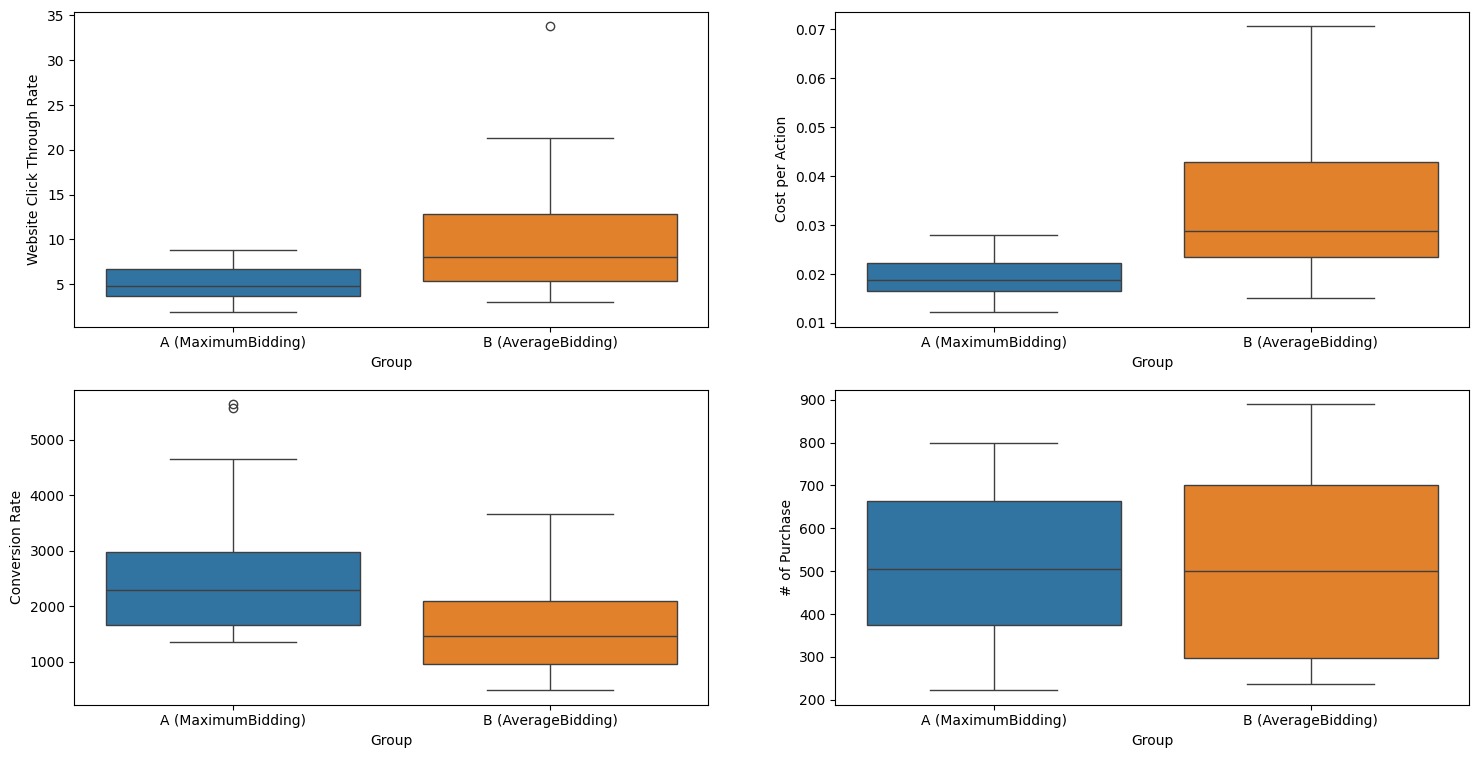

In [68]:
cols = ["Website Click Through Rate","Cost per Action","Conversion Rate","# of Purchase"]
show_boxplot(2,2,[0,1],cols,(18,9))

In [70]:
#TODO : create your dataframe for AB test and print the first 3 rows of it.
df_AB = data_prepare_for_hypothesis_testing(control_nop, test_nop)
df_AB.head(3)

,A,B
0,618,255
1,511,677
2,372,578


## 5. Two Independent Sample T-Test
### 5.1. Assumption Check
#### 5.1.1. Normality Assumption (shapiro test)

 * **H0**: Normal distribution assumption is provided.
 * **H1**: ... not provided.

In [71]:
#TODO : Aply the normality assumption of the dataframe for A
stat_A, p_A = stats.shapiro(df_AB["A"])
print("Group A p-value:", round(p_A, 3))

Group A p-value: 0.108


In [72]:
#TODO : compute p_value for normality on group A from the df_AB dataframe and round it to three decimal places.
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

checkReject(p_A)

#Analysis: it cannot be rejected since it's more than the alpha of 0.05 And normlaly idstributied.

0.10821626663232115 > alpha(0.05) so >>> H0 CAN'T BE REJECTED


Does the HO hypothesis get rejected ? why ?

In [73]:
#TODO : Aply the normality assumption of the dataframe for B
stat_B, p_B = shapiro(df_AB["B"])
print("Group B p-value:", round(p_B, 3))

Group B p-value: 0.024


In [74]:
#TODO : compute p_value for normality on group B from the df_AB dataframe and round it to three decimal places.
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.
checkReject(p_B)

#Analsyis: can be rejected since its less than alpha and the data is not normally distributed for group b.

0.02407767129664654 < alpha(0.05) so >>> H0 REJECTED


Does the HO hypothesis get rejected ? why ?

### 5.1.2. Variance Homogeneity Assumption
 * **H0** : Variances are homogeneous.
 * **H1** : Variances are not homogeneous.

We want to assess if A and B have equal variances, which is a common assumption for various statistical tests :

In [75]:
#TODO : Performs the Levene test for equality of variances on two groups, A and B, from the df_AB dataframe

stat, p = levene(df_AB["A"], df_AB["B"])
p_rounded = round(p, 3)

In [76]:
#TODO : compute the p_value of the df_AB dataframe and round it to three decimal places.

print("Levene Test p-value:", p_rounded)
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

checkReject(p_rounded)

Levene Test p-value: 0.199
0.199 > alpha(0.05) so >>> H0 CAN'T BE REJECTED



Conclude about the variances, are they homogeneous ?

Analsyis: Yes, they are / they have similar variance. ,

### 5.1.3. Nonparametric Independent Two-Sample T-Test

- Since the normality of the distribution of the data set in which Average Bidding (Test Group) was measured was rejected, the NonParametric Independent Two-Sample T Test was applied for the Hypothesis Test.

**Hypothesis:**

 * **H0** : When it comes to Maximum Bidding and Average Bidding, there is no statistically significant difference between the purchasing amounts of the two groups. ($\mu_1 = \mu_2$)

 * **H1** : ... there is a difference ($\mu_1 \neq \mu_2$)

In [77]:
# Average Biddingin (Test Group)
u_stat, p_value = stats.mannwhitneyu(df_AB["A"], df_AB["B"])

In [78]:
#TODO : compute the p_value of the df_AB dataframe and round it to three decimal places.

p_value_rounded = round(p_value, 3)
print("Mann-Whitney U p-value:", p_value_rounded)
#TODO : pass it to a function checkReject to determine if the null hypothesis of normality should be rejected.

checkReject(p_value_rounded)

Mann-Whitney U p-value: 0.947
0.947 > alpha(0.05) so >>> H0 CAN'T BE REJECTED


Should the H0 hypothesis be rejected ? Why ? What can you conclude ?
#Cannot be rejected because the score is greater than the alpha.

## 6. Conclusion and Evaluation


##### You should answer the following questions :


**1. How would you define the hypothesis of this A/B test ?**

##THere is no purchase difference between the two groups.
   
**2. Can we conclude statistically significant results?**

##There is no significant difference detected.


**3. Which statistical test did you use, and why?**
   
##I used Mann-Whitney due to nonormality.
**4. Based on your answer to Question 2, what would be your recommendation to client?**

#Keep the existing approach (bidding strategy).